# Moment Tensor Amplitude Inversion
## The inverse crime edition

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
from obspy.imaging.beachball import beachball
from obspy.imaging.beachball import beach

from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.linalg import lstsq

from pylops.basicoperators import HStack, VStack
from pylops.utils import dottest
from pylops.utils.wavelets import *
from pylops.optimization.sparsity import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from pyfrac.mtsolvers.homo_mti import collect_source_angles, pwave_Greens_comp
from pyfrac.mtsolvers.mtutils import get_mt_computation_dict
from pyfrac.mtsolvers.mtai import *

from pyfrac.visualisation.eventimages import locimage3d

# 3D Model - Homo

In [3]:
# Velocity Model
nx, ny, nz = 47, 51, 75
dx, dy, dz = 4, 4, 4
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 1000 # initial velocity
kv = 0. # gradient
vel = v0 * np.ones([nx, ny, nz])

(3, 143)
[[  4.  180.  162.4 144.8 127.2 109.6  92.   74.4  56.8  39.2  21.6   4.
  180.  162.4 144.8]
 [  4.    4.   20.   36.   52.   68.   84.  100.  116.  132.  148.  164.
  164.  180.  196. ]
 [  4.    4.    4.    4.    4.    4.    4.    4.    4.    4.    4.    4.
    4.    4.    4. ]]
[  4.  20.  36.  52.  68.  84. 100. 116. 132. 148. 164. 180. 196.] 200 [  4.   21.6  39.2  56.8  74.4  92.  109.6 127.2 144.8 162.4 180. ] 184


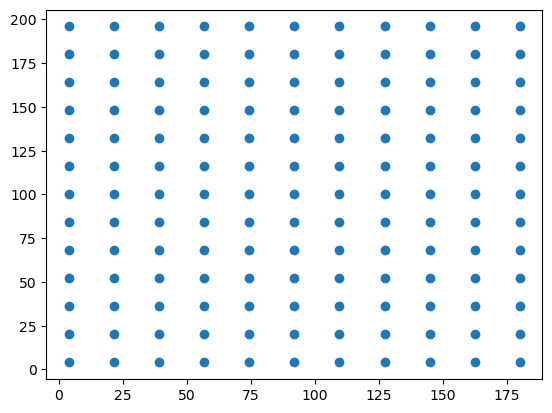

In [4]:
# RECEIVERS
grid_rx_locs = np.linspace(dx, (dx*nx)-2*dx, 11)
grid_ry_locs = np.linspace(dy, (dy*ny)-2*dy, 13)

rx, ry, rz = np.meshgrid(grid_rx_locs,
                         grid_ry_locs,
                         dz) 
recs = np.vstack((rx.flatten(), ry.flatten(), rz.flatten()))
nr = recs.shape[1]

plt.scatter(rx,ry)
print(recs.shape)
print(recs[:,::10])
print(grid_ry_locs, y.max(), grid_rx_locs, x.max())

## Get all necessary components

In [5]:
# AMPLITUDE TERMS
gamma_sourceangles, dist_table = collect_source_angles(x,y,z, reclocs=recs, nc=3)

In [6]:
# Source Parameters
omega_p = 30  # Assume central frequency of 25Hz
sloc_ind = [nx//2, ny//2, nz//2]  # As indices of velocity model

In [7]:
MT_comp_dict = get_mt_computation_dict()  # This keeps everything nice and clean in the later G compute

In [13]:
MT_comp_dict

[{'elementID': 0,
  'laymans': 'xx',
  'pq': [0, 0],
  'ODscaler': 1,
  'MCweighting': 1},
 {'elementID': 1,
  'laymans': 'yy',
  'pq': [1, 1],
  'ODscaler': 1,
  'MCweighting': 1},
 {'elementID': 2,
  'laymans': 'zz',
  'pq': [2, 2],
  'ODscaler': 1,
  'MCweighting': 1},
 {'elementID': 3,
  'laymans': 'xy',
  'pq': [0, 1],
  'ODscaler': 2,
  'MCweighting': 1},
 {'elementID': 4,
  'laymans': 'xz',
  'pq': [0, 2],
  'ODscaler': 2,
  'MCweighting': 1},
 {'elementID': 5,
  'laymans': 'yz',
  'pq': [1, 2],
  'ODscaler': 2,
  'MCweighting': 1}]

## Compute Greens for area of interest

In [8]:
Gz = pwave_Greens_comp(gamma_sourceangles,
                        dist_table,
                        sloc_ind,
                        vel,
                        MT_comp_dict,
                        comp_gamma_ind=2,
                        omega_p=omega_p,
                        )

In [9]:
Gz.shape

(6, 143)

# Single Event Example

In [10]:
# Modelled MT
mt =-1 * np.array([0,0,0,1,0,0]) #  np.array([1,1,1,0,0,0]) 

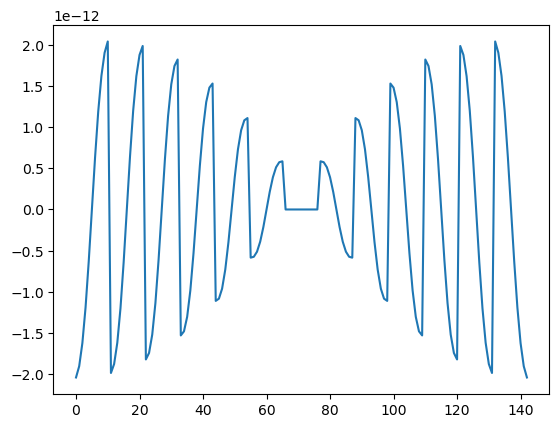

In [11]:
# Forward
p_amps = frwrd_mtmodelling(Gz, mt)
plt.plot(p_amps)

[-3.64765835e-18  6.68948167e-18 -8.41956495e-19 -1.00000000e+00
 -1.50414682e-16  1.00814488e-18]
[ 3.64765835e-18 -6.68948167e-18  8.41956495e-19  2.22044605e-16
  1.50414682e-16 -1.00814488e-18]


Text(0.5, 1.0, 'MT Amplitude Inversion')

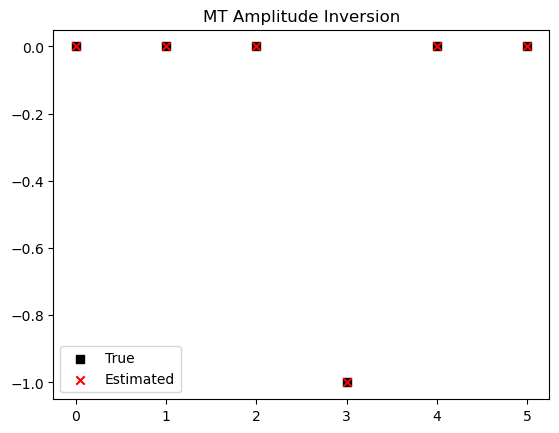

In [12]:
# LSQR Inversion
mt_est = lsqr_mtsolver(Gz, p_amps)
print(mt_est)
print(mt-mt_est)

plt.scatter(range(6), mt, c='k', marker='s', label='True')
plt.scatter(range(6), mt_est, c='r', marker='x', label='Estimated')
plt.legend()
plt.title('MT Amplitude Inversion')

In [35]:
def _mt4plt(mt):
    ''' Make MT into matrix with np.nan padded border version (for plotting purposes) 
    '''
    mat_mt = np.empty([3,3])
    mat_mt[0,0] = mt[0]  # M_{x,x}
    mat_mt[1,1] = mt[1]  # M_{y,y}
    mat_mt[2,2] = mt[2]  # M_{z,z}    
    mat_mt[0,1] = mt[3]  # M_{x,y}
    mat_mt[1,0] = mt[3]  # M_{y,x}    
    mat_mt[0,2] = mt[4]  # M_{x,z}
    mat_mt[2,0] = mt[4]  # M_{z,x}    
    mat_mt[1,2] = mt[5]  # M_{y,z}
    mat_mt[2,1] = mt[5]  # M_{z,y}

    # Make padded for plot
    mat_mt4plt = np.empty([5,5])
    mat_mt4plt[1:-1,1:-1] = mat_mt
    mat_mt4plt[0] = np.nan
    mat_mt4plt[-1] = np.nan
    mat_mt4plt[:,0] = np.nan
    mat_mt4plt[:,-1] = np.nan
    return mat_mt, mat_mt4plt
    
def MTMatrixplot(ax,mt):
    cmap = matplotlib.cm.Spectral
    cmap.set_bad('w',1.)

    mt_matrix, mat_mt4plt = _mt4plt(mt)
    ax.imshow(mat_mt4plt, cmap=cmap, vmin=-1, vmax=1)
    # Add lines around matrix
    linlocs = [0.5,1.5,2.5,3.5]
    for loc in linlocs: 
        ax.hlines(y=loc,xmin=0.5,xmax=3.5, color='k')
        ax.vlines(x=loc,ymin=0.5,ymax=3.5, color='k')
    ax.set_xlim([0.25,3.75]); ax.set_ylim([3.75,0.25]);

    # Add text showing MT values
    ax.text(1,1,'%.1f'%mt_matrix[0,0], va='center', ha='center', fontweight='bold', fontsize=14)
    ax.text(2,2,'%.1f'%mt_matrix[1,1], va='center', ha='center', fontweight='bold', fontsize=14)
    ax.text(3,3,'%.1f'%mt_matrix[2,2], va='center', ha='center', fontweight='bold', fontsize=14)
    ax.text(1,2,'%.1f'%mt_matrix[0,1], va='center', ha='center', fontweight='bold', fontsize=14)
    ax.text(2,1,'%.1f'%mt_matrix[0,1], va='center', ha='center', fontweight='bold', fontsize=14)
    ax.text(1,3,'%.1f'%mt_matrix[0,2], va='center', ha='center', fontweight='bold', fontsize=14)
    ax.text(3,1,'%.1f'%mt_matrix[0,2], va='center', ha='center', fontweight='bold', fontsize=14)
    ax.text(3,2,'%.1f'%mt_matrix[1,2], va='center', ha='center', fontweight='bold', fontsize=14)
    ax.text(2,3,'%.1f'%mt_matrix[1,2], va='center', ha='center', fontweight='bold', fontsize=14)

    # Title
    ax.text(2,0.25,'Source Moment Tensor', va='center', ha='center', fontweight='bold', fontsize=14)
    ax.set_facecolor('w')
    ax.axis('off')

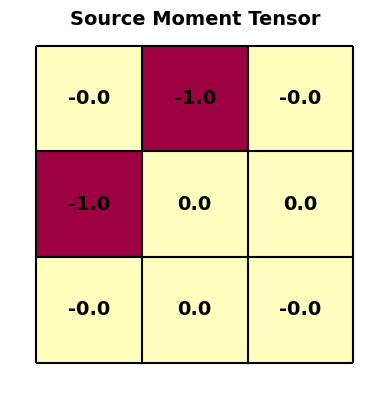

In [36]:
fig,ax = plt.subplots(1,1)
MTMatrixplot(ax,mt_est)

In [37]:
mt_matrix, mat_mt4plt = _mt4plt(mt_est)

In [38]:
mt_matrix

array([[-3.64765835e-18, -1.00000000e+00, -1.50414682e-16],
       [-1.00000000e+00,  6.68948167e-18,  1.00814488e-18],
       [-1.50414682e-16,  1.00814488e-18, -8.41956495e-19]])

In [39]:
mt_est

array([-3.64765835e-18,  6.68948167e-18, -8.41956495e-19, -1.00000000e+00,
       -1.50414682e-16,  1.00814488e-18])